<a href="https://colab.research.google.com/github/jellydaniellie/cs6501-final/blob/main/DSDaily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import pandas as pd

# Load JSON
with open('/content/drive/MyDrive/Colab Notebooks/online behavior final/des data/ds_life_events.json') as f:
    life_events = json.load(f)

# Convert to DataFrame
events_df = pd.DataFrame(life_events['events'])
events_df['date'] = pd.to_datetime(events_df['date'])

# Full date range (daily)
full_dates = pd.date_range(start='2025-01-07', end='2025-04-26')
binary_series = pd.DataFrame({'Date': full_dates})

# Overall event occurrence
binary_series['Event Occurred'] = binary_series['Date'].isin(events_df['date']).astype(int)

# Unique event types
event_types = events_df['event'].unique()

# Add separate binary columns per event type
for event_type in event_types:
    dates_of_type = events_df.loc[events_df['event'] == event_type, 'date']
    binary_series[event_type] = binary_series['Date'].isin(dates_of_type).astype(int)

print(binary_series.head())


        Date  Event Occurred  start of classes  interview  holiday  birthday  \
0 2025-01-07               0                 0          0        0         0   
1 2025-01-08               0                 0          0        0         0   
2 2025-01-09               0                 0          0        0         0   
3 2025-01-10               0                 0          0        0         0   
4 2025-01-11               0                 0          0        0         0   

   shelter-in-place  school break  illness  
0                 0             0        0  
1                 0             0        0  
2                 0             0        0  
3                 0             0        0  
4                 0             0        0  


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.4/208.4 kB 3.3 MB/s eta 0:00:00


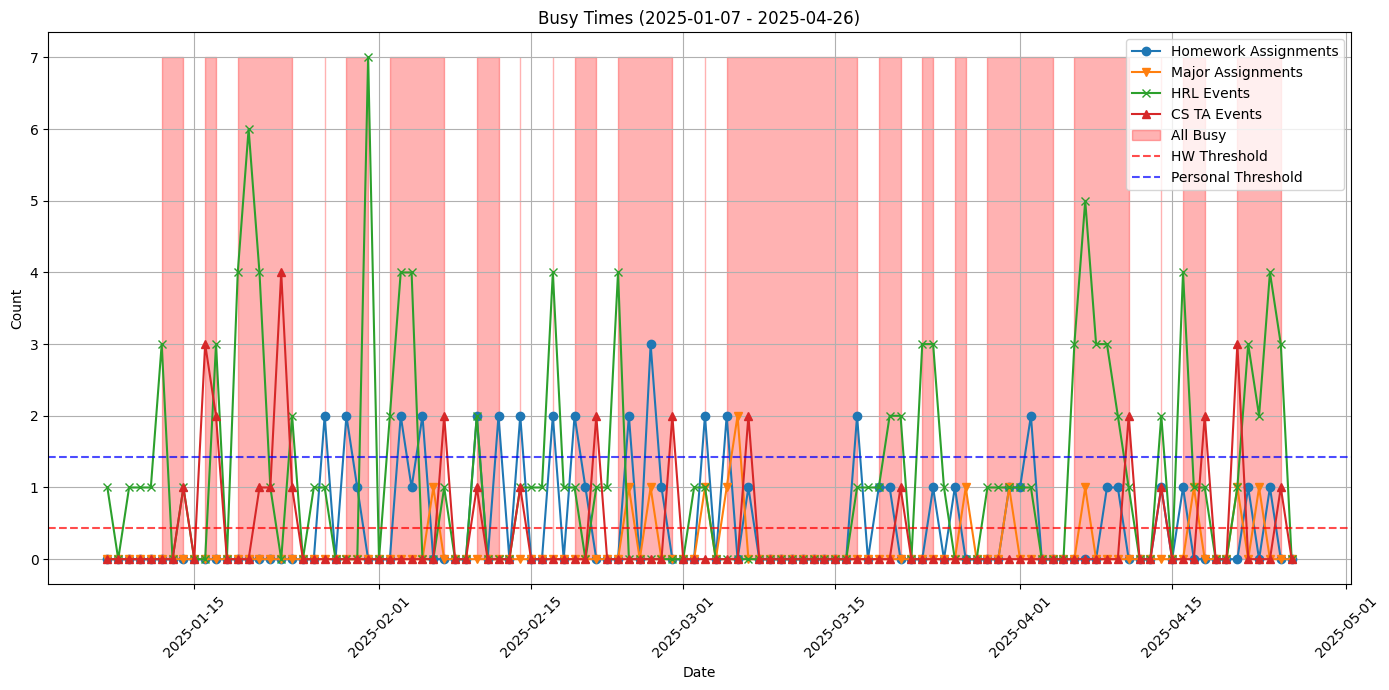

In [ ]:
!pip install icalendar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import icalendar
from datetime import datetime, timedelta
import os

# -------------------- SETTINGS --------------------
HOMEWORK_CSV = "/content/drive/MyDrive/Colab Notebooks/online behavior final/des data/HomeworkTracker.csv"
HRL_CALENDAR_ICS = "/content/drive/MyDrive/Colab Notebooks/online behavior final/des data/HRL.ics"
CS_CALENDAR_ICS = "/content/drive/MyDrive/Colab Notebooks/online behavior final/des data/CS 111x.ics"
CALENDAR_ICS = 'combined_calendar.ics'
START_DATE = "2025-01-07"               # Semester start date
END_DATE = "2025-04-26"                 # Semester end date
BUSY_HW_THRESHOLD = "mean"              # "mean", "median", or a fixed number
BUSY_PERSONAL_THRESHOLD = "mean"         # "mean", "median", or a fixed number
# ---------------------------------------------------


def load_homework(csv_path, start_date, end_date):
  df = pd.read_csv(csv_path)
  df['Due date'] = pd.to_datetime(df['Due date'], errors='coerce')
  df = df[(df['Due date'] >= start_date) & (df['Due date'] <= end_date)]
  df['Date'] = df['Due date'].dt.date

  major_task_types = ['Quiz', 'Presentation', 'Exam', 'Paper']
  hw_counts = df.loc[~df['Task type'].isin(major_task_types)].groupby('Date').size()
  major_counts = df.loc[df['Task type'].isin(major_task_types)].groupby('Date').size()
  return hw_counts, major_counts

def load_calendar(ics_path, start_date, end_date):
  with open(ics_path, 'rb') as f:
    cal = icalendar.Calendar.from_ical(f.read())

  events = []
  for component in cal.walk():
      if component.name == "VEVENT":
        dtstart = component.get('dtstart').dt
        if isinstance(dtstart, datetime):
          dtstart = pd.Timestamp(dtstart).tz_localize(None)
          if start_date <= dtstart <= end_date:
              events.append(dtstart)

  df = pd.DataFrame({'Start': events})
  df['Date'] = df['Start'].dt.date
  #df['Week Start'] = df['Start'].dt.to_period('W').apply(lambda r: r.start_time)
  personal_counts = df.groupby('Date').size()
  return personal_counts

def determine_busy_weeks(counts, threshold_rule):
  if threshold_rule == "mean":
    threshold = counts.mean()
  elif threshold_rule == "median":
    threshold = counts.median()
  else:
    threshold = float(threshold_rule)
  return counts > threshold, threshold


start_date = pd.to_datetime(START_DATE)
end_date = pd.to_datetime(END_DATE)

hw_counts, major_counts = load_homework(HOMEWORK_CSV, start_date, end_date)

hrl_counts = load_calendar(HRL_CALENDAR_ICS, start_date, end_date)

cs_counts = load_calendar(CS_CALENDAR_ICS, start_date, end_date)

personal_counts = hrl_counts + cs_counts

days = pd.date_range(start=start_date, end=end_date, freq='D')
combined = pd.DataFrame({'Date': days})

combined['Homework Assignments'] = combined['Date'].map(hw_counts).fillna(0)
combined['Major Assignments'] = combined['Date'].map(major_counts).fillna(0)

combined['HRL Events'] = combined['Date'].map(hrl_counts).fillna(0)
combined['CS Events'] = combined['Date'].map(cs_counts).fillna(0)
combined['Personal Events'] = combined['HRL Events'] + combined['CS Events']

combined['Homework Assignments'] = combined['Homework Assignments'].astype(int)
combined['Major Assignments'] = combined['Major Assignments'].astype(int)

combined['HRL Events'] = combined['HRL Events'].astype(int)
combined['CS Events'] = combined['CS Events'].astype(int)
combined['Personal Events'] = combined['Personal Events'].astype(int)

busy_academic, hw_threshold = determine_busy_weeks(combined['Homework Assignments'], BUSY_HW_THRESHOLD)
busy_personal, personal_threshold = determine_busy_weeks(combined['Personal Events'], BUSY_PERSONAL_THRESHOLD)


combined['Busy Academic'] = busy_academic.astype(int)
combined['Significant Assignments'] = combined['Major Assignments'].astype(bool).astype(int)

#print(combined.loc[combined['Academic Pressure Day']==1])

combined['Busy Personal'] = busy_personal.astype(int)
combined['Academic Pressure Day'] = (combined['Busy Personal'] | combined['Busy Academic'] | (combined['Significant Assignments'] > 0) | binary_series['Event Occurred']).astype(int)

# combined['Homework Moving Avg'] = combined['Homework Assignments'].rolling(window=7).mean()
# combined['Personal Moving Avg'] = combined['Personal Events'].rolling(window=7).mean()

# combined['Homework Moving Avg'] = combined['Homework Moving Avg'].fillna(0)
# combined['Personal Moving Avg'] = combined['Personal Moving Avg'].fillna(0)

plt.figure(figsize=(14, 7))
plt.plot(combined['Date'], combined['Homework Assignments'], label='Homework Assignments', marker='o',)
plt.plot(combined['Date'], combined['Major Assignments'],label='Major Assignments',marker='v')
plt.plot(combined['Date'], combined['HRL Events'], label='HRL Events', marker='x' )
plt.plot(combined['Date'], combined['CS Events'], label='CS TA Events', marker='^')

plt.fill_between(combined['Date'], 0, max(combined['Homework Assignments'].max(), combined['Personal Events'].max()),
                     where=combined['Academic Pressure Day'], color='red', alpha=0.3, label='All Busy')

plt.axhline(hw_threshold, color='red', linestyle='--', alpha=0.7, label='HW Threshold')
plt.axhline(personal_threshold, color='blue', linestyle='--', alpha=0.7, label='Personal Threshold')

plt.title('Busy Times ({} - {})'.format(START_DATE, END_DATE))
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

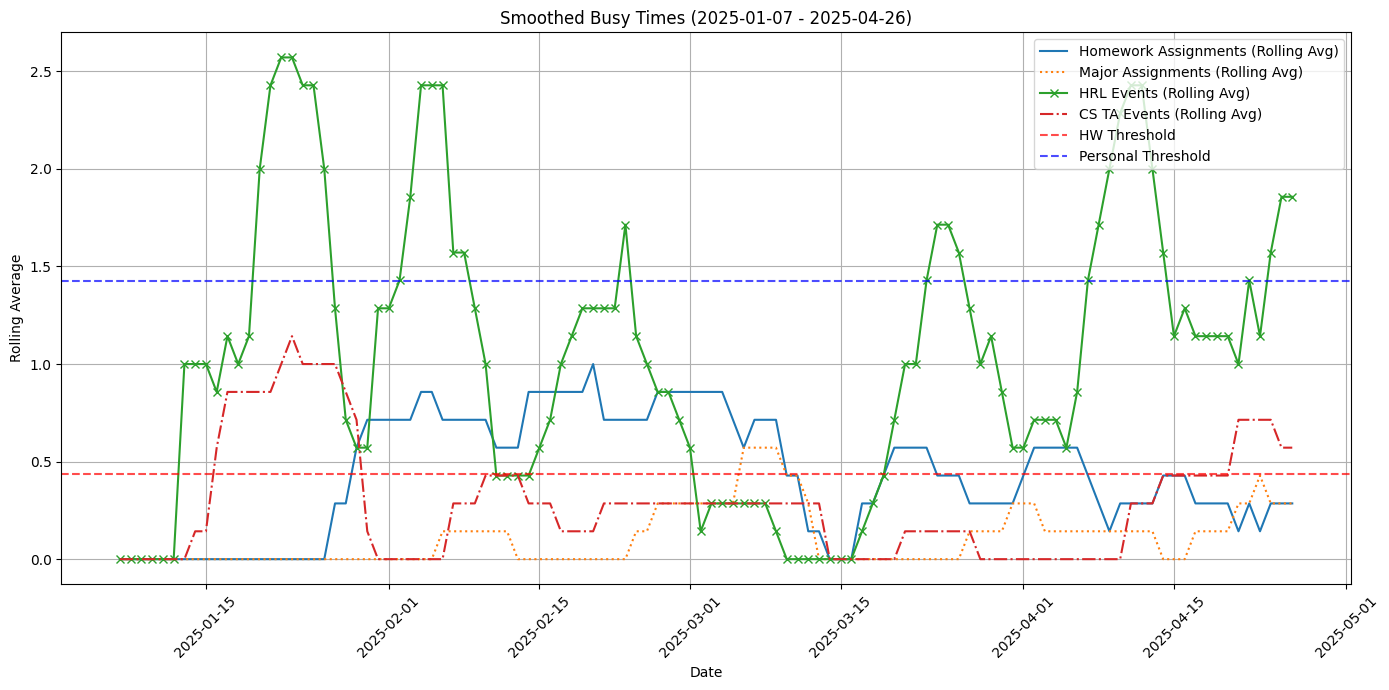

In [ ]:
# Calculate rolling averages (7-day window)
combined['Homework Assignments Rolling Avg'] = combined['Homework Assignments'].rolling(window=7).mean().fillna(0)
combined['Major Assignments Rolling Avg'] = combined['Major Assignments'].rolling(window=7).mean().fillna(0)
combined['HRL Events Rolling Avg'] = combined['HRL Events'].rolling(window=7).mean().fillna(0)
combined['CS Events Rolling Avg'] = combined['CS Events'].rolling(window=7).mean().fillna(0)

# Plot the rolling averages
plt.figure(figsize=(14, 7))
plt.plot(combined['Date'], combined['Homework Assignments Rolling Avg'], label='Homework Assignments (Rolling Avg)')
plt.plot(combined['Date'], combined['Major Assignments Rolling Avg'], label='Major Assignments (Rolling Avg)', linestyle=':')
plt.plot(combined['Date'], combined['HRL Events Rolling Avg'], label='HRL Events (Rolling Avg)', marker='x')
plt.plot(combined['Date'], combined['CS Events Rolling Avg'], label='CS TA Events (Rolling Avg)', linestyle='-.')

# Highlight busy times based on the smoothed data
# plt.fill_between(combined['Date'], 0, max(combined['Homework Assignments Rolling Avg'].max(), combined['Personal Events'].max()),
#                      where=combined['Academic Pressure Day'], color='red', alpha=0.3, label='All Busy')

# Add threshold lines (unchanged)
plt.axhline(hw_threshold, color='red', linestyle='--', alpha=0.7, label='HW Threshold')
plt.axhline(personal_threshold, color='blue', linestyle='--', alpha=0.7, label='Personal Threshold')

# Set the plot title, labels, and legend
plt.title('Smoothed Busy Times ({} - {})'.format(START_DATE, END_DATE))
plt.xlabel('Date')
plt.ylabel('Rolling Average')
plt.legend(loc='upper right')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Found 31378 entries.
Threshold: 55.87619047619047
          Date  watch_count  Viewing Spike
104 2025-01-07            2              0
103 2025-01-09            6              0
102 2025-01-10           26              0
101 2025-01-11           29              0
100 2025-01-12          350              1


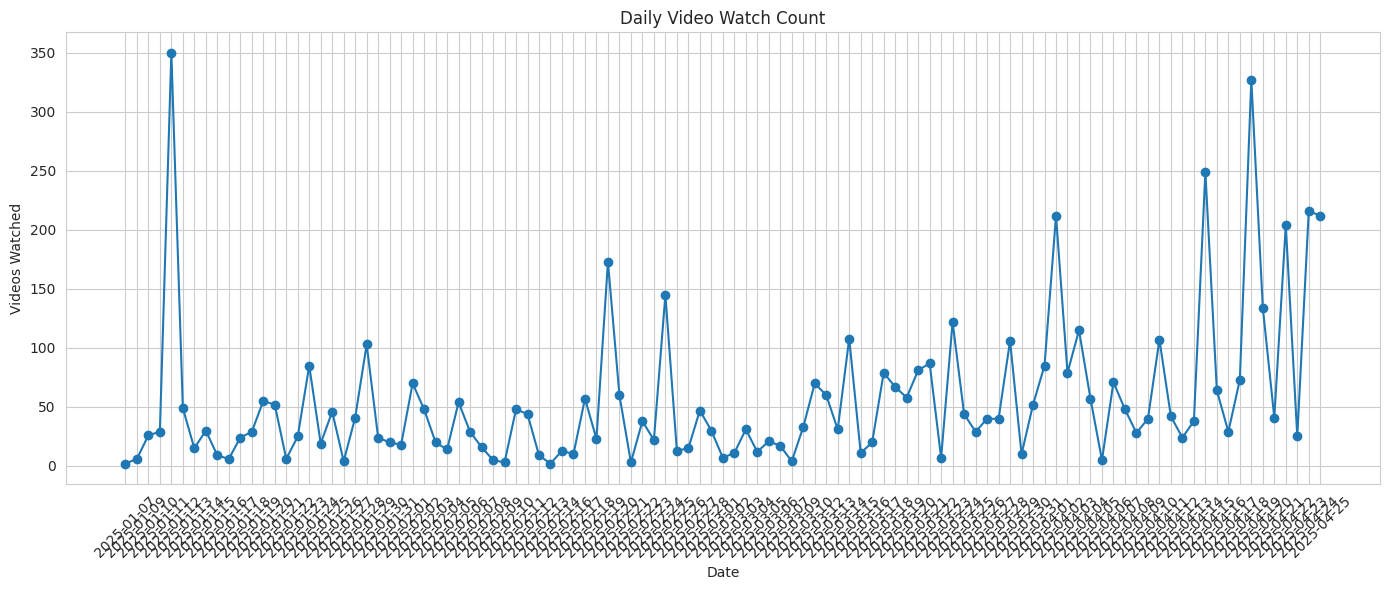

          Date  watch_count  Viewing Spike  Sentiment
104 2025-01-07            2              0     0.9663
103 2025-01-09            6              0    -0.6597
102 2025-01-10           26              0     0.0000
101 2025-01-11           29              0     0.0000
100 2025-01-12          350              1     0.0000


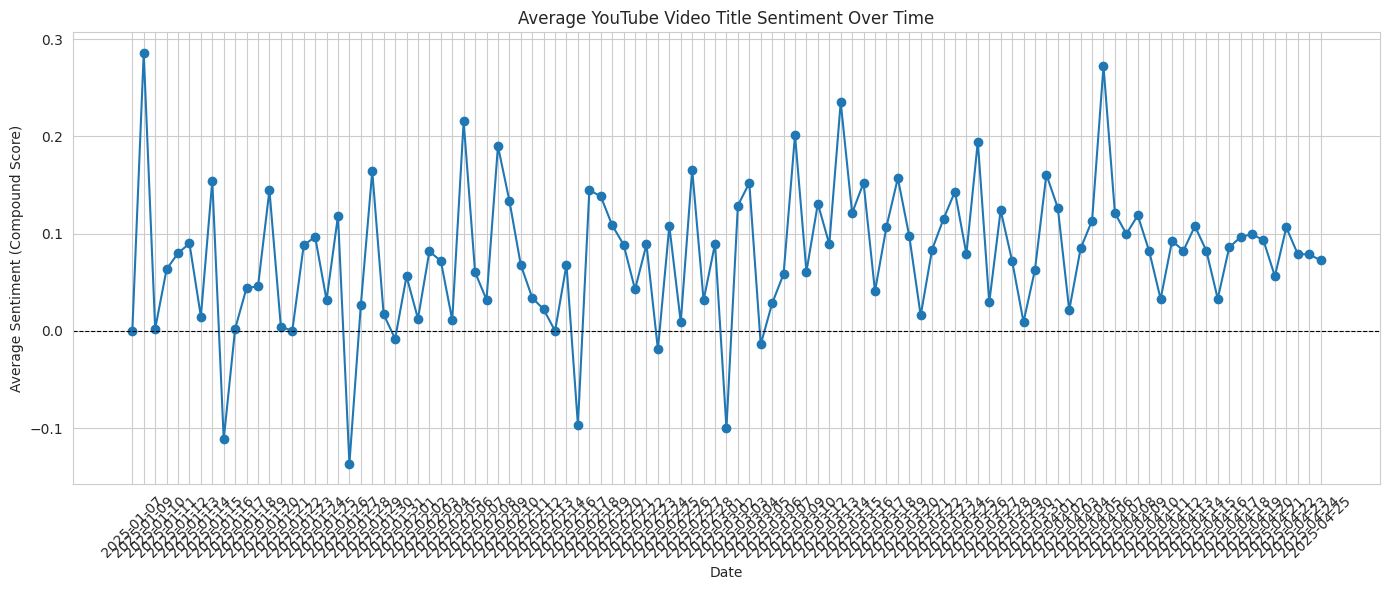

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

In [ ]:
#!pip install vaderSentiment
import re
import csv
from datetime import datetime, timedelta
from collections import defaultdict
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

start_date = datetime(2025, 1, 7)
end_date = datetime(2025, 4, 26)

analyzer = SentimentIntensityAnalyzer()

# Initialize counters
day_counts = defaultdict(int)
filtered_entries = []
# Read the HTML content
with open("/content/drive/MyDrive/Colab Notebooks/online behavior final/des data/watch-history.html", "r", encoding="utf-8") as f:
    html_content = f.read()

# Find each outer block
entries = re.findall(r'<div class="outer-cell.*?mdl-shadow--2dp">(.*?)</div></div>', html_content, re.DOTALL)
print(f"Found {len(entries)} entries.")

for entry in entries:
    # Extract the "Watched" or "Viewed" action + video
    links = re.findall(r'<a href="([^"]+)">([^<]+)</a>', entry)

    video_url, video_title = None, None
    channel_url, channel_name = None, None

    if len(links) >= 1:
      video_url, video_title = links[0]  # first <a> is always the video
    if len(links) >= 2:
      channel_url, channel_name = links[1]  # second <a> is the channel

    # Extract timestamp
    timestamp_match = re.search(r'(\w{3} \d{1,2}, \d{4}, \d{1,2}:\d{2}:\d{2}.*?(EDT|EST|UTC|PDT|PST))', entry) # Modified regex to capture the timezone
    timestamp_str = timestamp_match.group(1) if timestamp_match else None

    # Parse to datetime object, handling timezone
    try:
        timestamp_dt = datetime.strptime(timestamp_str, "%b %d, %Y, %I:%M:%S %p %Z") # Added %Z to parse timezone
    except ValueError:
        # If %Z fails, try without timezone (some entries might not have it)
        timestamp_dt = datetime.strptime(timestamp_str[:-4], "%b %d, %Y, %I:%M:%S %p") # Removed last 4 char for timezone and parsed.

    # Check if within range
    if start_date <= timestamp_dt <= end_date:
        #print(video_title, video_url, channel_name, channel_url, timestamp_dt)
        day_str = timestamp_dt.strftime("%Y-%m-%d")       # e.g., 2025-04-25
        sentiment = analyzer.polarity_scores(video_title)
        #print(sentiment)
        filtered_entries.append({
                        'Date': day_str,  # Just the date part
                        'Title': video_title,
                        'Compound': sentiment['compound']  # overall sentiment score
                    })
        day_counts[day_str] += 1


youtube_threshold = sum(list(day_counts.values())) / len(day_counts)
print('Threshold:', youtube_threshold)

# Create DataFrame from daily counts
youtube_daily_df = pd.DataFrame(list(day_counts.items()), columns=['Date', 'watch_count'])
youtube_daily_df['Date'] = pd.to_datetime(youtube_daily_df['Date'])
youtube_daily_df = youtube_daily_df.sort_values('Date')

# Apply threshold to create binary series
youtube_daily_df['Viewing Spike'] = (youtube_daily_df['watch_count'] > youtube_threshold).astype(int)
youtube_daily_df.to_csv('youtube_daily_df.csv', index=False)
# Show first few rows
print(youtube_daily_df.head())

import matplotlib.pyplot as plt

# Plot Daily Counts
days = sorted(day_counts.keys())
counts = [day_counts[day] for day in days]

plt.figure(figsize=(14,6))
plt.plot(days, counts, marker='o')
plt.title('Daily Video Watch Count')
plt.xlabel('Date')
plt.ylabel('Videos Watched')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


daily_sentiment_df = pd.DataFrame(filtered_entries)

# Aggregate by date: average the sentiment
youtube_daily_df['Sentiment'] = daily_sentiment_df['Compound']

print(youtube_daily_df.head())
# # Plot
plt.figure(figsize=(14,6))
plt.plot(daily_sentiment.index, daily_sentiment.values, marker='o')
plt.title('Average YouTube Video Title Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment (Compound Score)')
plt.axhline(0, color='black', linestyle='--', lw=0.8)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,6))


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame from daily counts
youtube_daily_df = pd.DataFrame(list(day_counts.items()), columns=['Date', 'watch_count'])
youtube_daily_df['Date'] = pd.to_datetime(youtube_daily_df['Date'])
youtube_daily_df = youtube_daily_df.sort_values('Date')

# Resample the data to weekly frequency (sum the counts per week)
youtube_weekly_df = youtube_daily_df.resample('W-Mon', on='Date').sum()  # 'W-Mon' gives weekly data starting from Monday

# Calculate the rolling average for each week's total count (e.g., 1-week rolling window)
youtube_weekly_df['Rolling Avg'] = youtube_weekly_df['watch_count'].rolling(window=1).mean()

# Plot the weekly rolling average
plt.figure(figsize=(14, 6))
plt.plot(youtube_weekly_df.index, youtube_weekly_df['Rolling Avg'], marker='o', label='Weekly Rolling Avg')
plt.title('Weekly Video Watch Count (Rolling Avg)')
plt.xlabel('Date')
plt.ylabel('Videos Watched')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


F_onewayResult(statistic=np.float64(2.681327608476302), pvalue=np.float64(0.0023066849707120995))


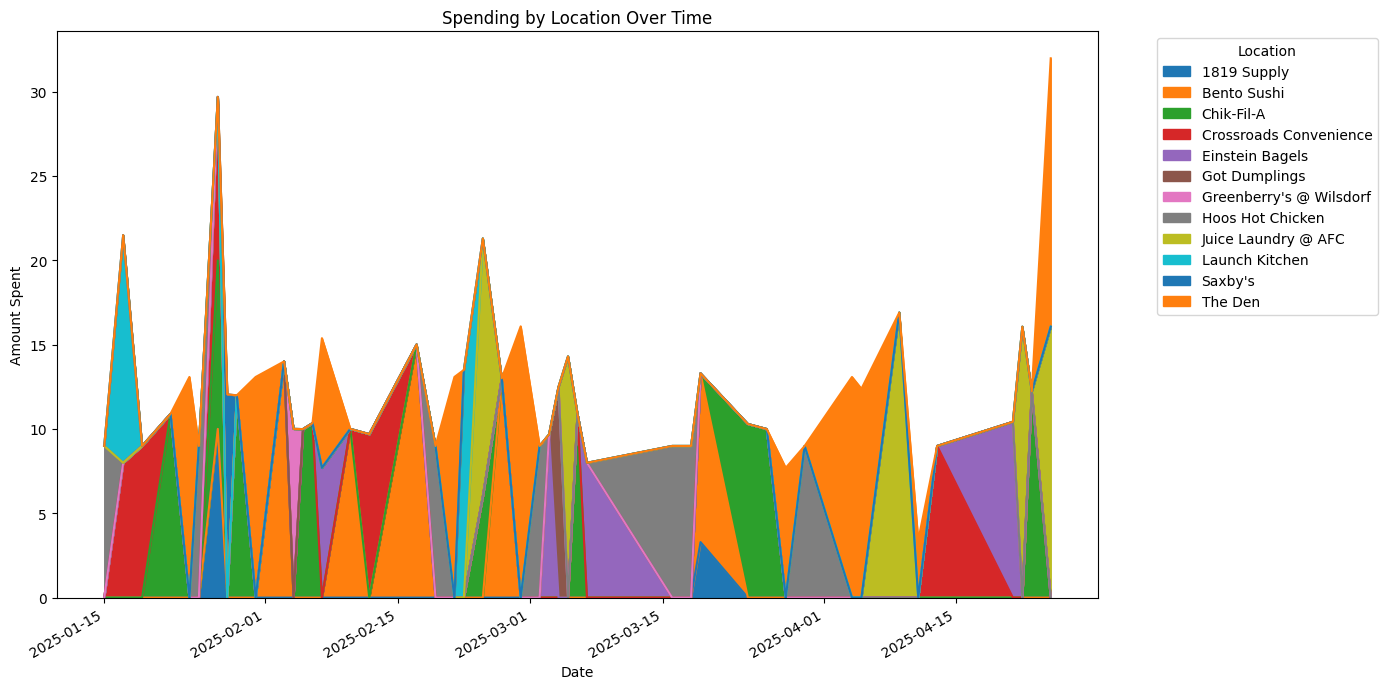

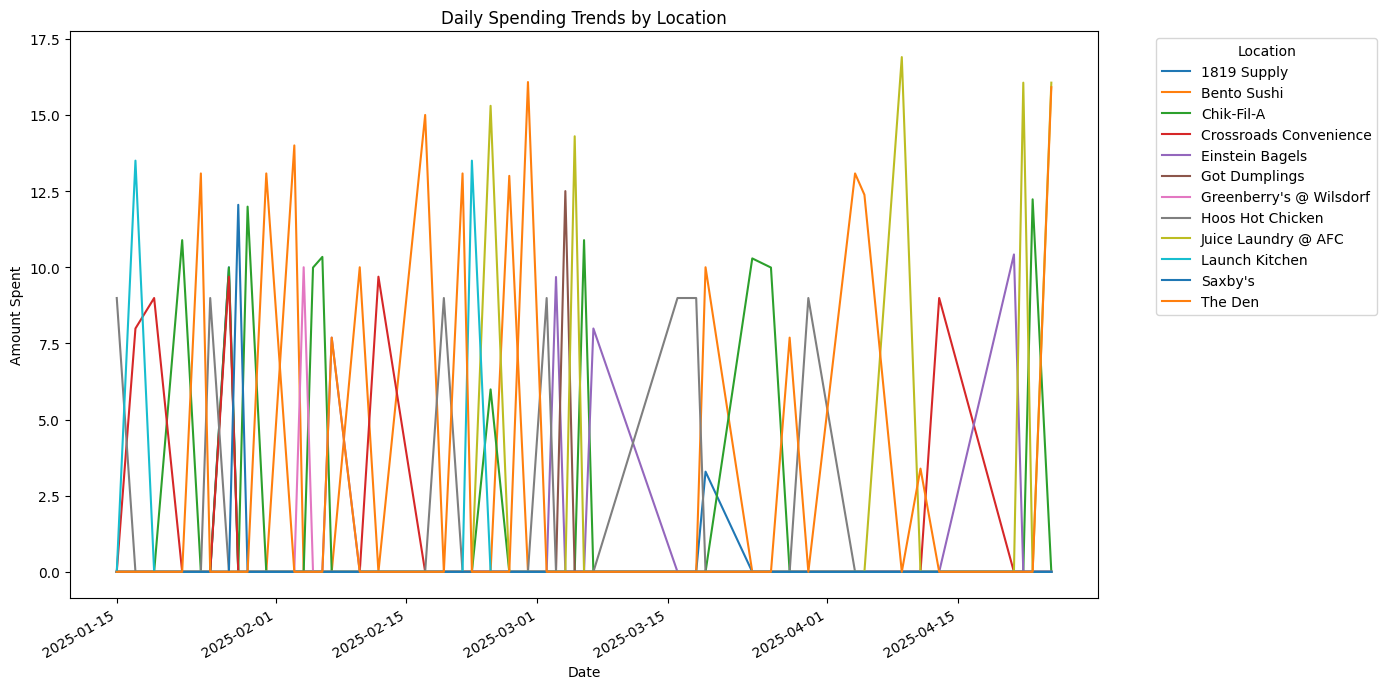

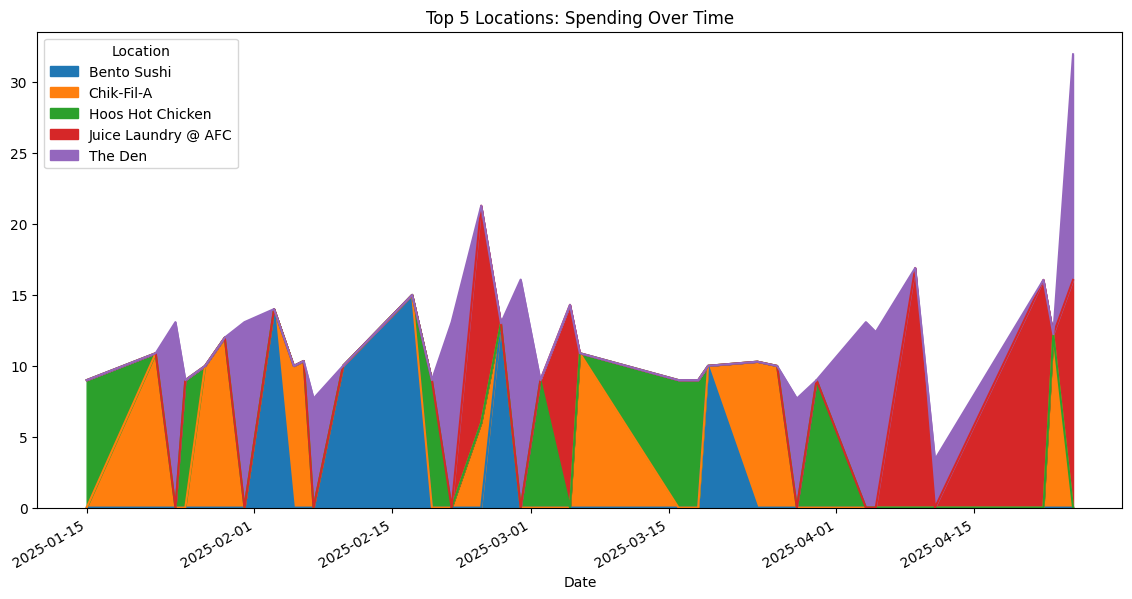

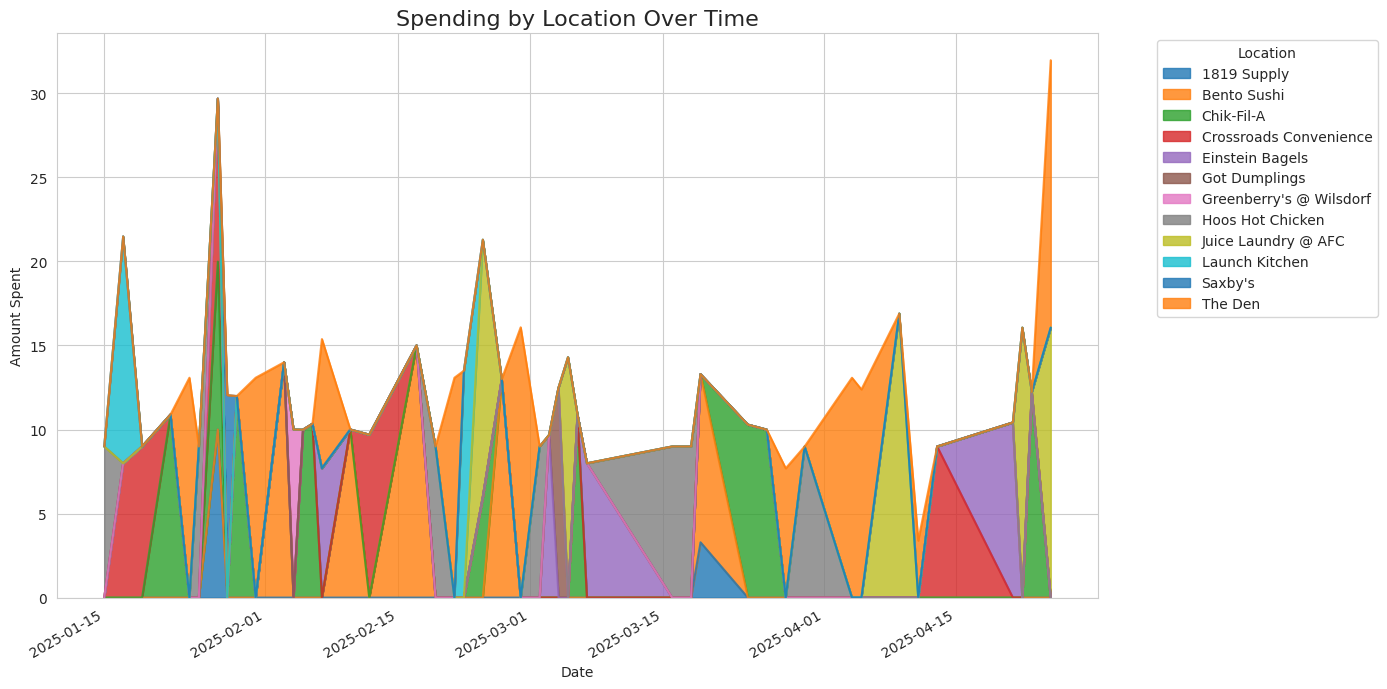

In [ ]:
#@title Food Spending
import pandas as pd
import matplotlib.pyplot as plt

location_dict = {'Chik-Fil-A - Grubhub - Kiosk': 'Chik-Fil-A',
                 'The Den - Grubhub - Kiosk': 'The Den',
                 'Grill at XRoads - Grubhub': 'Hoos Hot Chicken',
                 'XRoads C-Store-Micros SAAS':'Crossroads Convenience',
                 'Bento - Grubhub - Kiosk': 'Bento Sushi',
                 'Einsteins Rice - Grubhub - Kiosk': 'Einstein Bagels',
                 'Launch Kitchen - Grubhub - Kiosk': 'Launch Kitchen',
                 'POD Newcomb - Micros SAAS':'1819 Supply',
                 'Juice Laundry-AFC - Grubhub': 'Juice Laundry @ AFC',
                 "Shannon Lib. Saxby's - Grubhub": "Saxby's",
                 "Wilsdorf Greenberry's - Grubhub": "Greenberry's @ Wilsdorf",
                 'Got Dumplings - Grubhub': 'Got Dumplings'}

food_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/online behavior final/des data/DiningDollarUsage.csv")
food_df['Date'] = pd.to_datetime(food_df['Date'])
food_df = food_df.drop('Balance',axis=1)
food_df['Amount'] = food_df['Amount'].str.replace('$', '').str.replace(',', '').astype(float)

food_df['Location'] = food_df['Location'].replace(location_dict)

# Sum purchases daily
daily_food = food_df.groupby('Date')['Amount'].sum().rename('Spending per Day').reset_index()
daily_food['Transaction Count'] = food_df.groupby('Date').size().reset_index(name='count')['count']

daily_food['Location'] = food_df.groupby('Date')['Location'].apply(lambda x: x.value_counts().index[0])
# Calculate mean purchase amount
mean_food = daily_food['Spending per Day'].mean()

# Create Purchase Spike binary indicator
daily_food['Purchase Spike'] = (daily_food['Spending per Day'] > mean_food).astype(int)

#print(daily_food.head())

import scipy.stats as stats
location_daily_spend = food_df.groupby(['Date', 'Location'])['Amount'].sum().reset_index()
# Pivot so each location is a column
pivoted = location_daily_spend.pivot(index='Date', columns='Location', values='Amount').fillna(0)
# ANOVA across all locations
anova_result = stats.f_oneway(*[pivoted[col] for col in pivoted.columns])

print(anova_result)

pivoted.plot(kind='area', stacked=True, figsize=(14,7))

plt.title('Spending by Location Over Time')
plt.xlabel('Date')
plt.ylabel('Amount Spent')
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

pivoted.plot(kind='line', figsize=(14,7))

plt.title('Daily Spending Trends by Location')
plt.xlabel('Date')
plt.ylabel('Amount Spent')
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

top_locations = food_df.groupby('Location')['Amount'].sum().sort_values(ascending=False).head(5).index
filtered = location_daily_spend[location_daily_spend['Location'].isin(top_locations)]

pivoted_filtered = filtered.pivot(index='Date', columns='Location', values='Amount').fillna(0)

pivoted_filtered.plot(kind='area', stacked=True, figsize=(14,7))
plt.title('Top 5 Locations: Spending Over Time')
plt.show()

import seaborn as sns

sns.set_style("whitegrid")
pivoted.plot(kind='area', stacked=True, figsize=(14,7), alpha=0.8)
plt.title('Spending by Location Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Amount Spent')
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Mean Stress Score: 67.75490196078431


<ipython-input-19-16b47435b4ff>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stress_df['DATE'] = stress_df['DATE'].str.replace('T00:00:00', '') # Remove the time part
<ipython-input-19-16b47435b4ff>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stress_df['Date'] = pd.to_datetime(stress_df['DATE']) # Convert the 'DATE' column to datetime


(array([20103., 20120., 20134., 20148., 20162., 20179., 20193., 20209.]),
 [Text(20103.0, 0, '2025-01-15'),
  Text(20120.0, 0, '2025-02-01'),
  Text(20134.0, 0, '2025-02-15'),
  Text(20148.0, 0, '2025-03-01'),
  Text(20162.0, 0, '2025-03-15'),
  Text(20179.0, 0, '2025-04-01'),
  Text(20193.0, 0, '2025-04-15'),
  Text(20209.0, 0, '2025-05-01')])

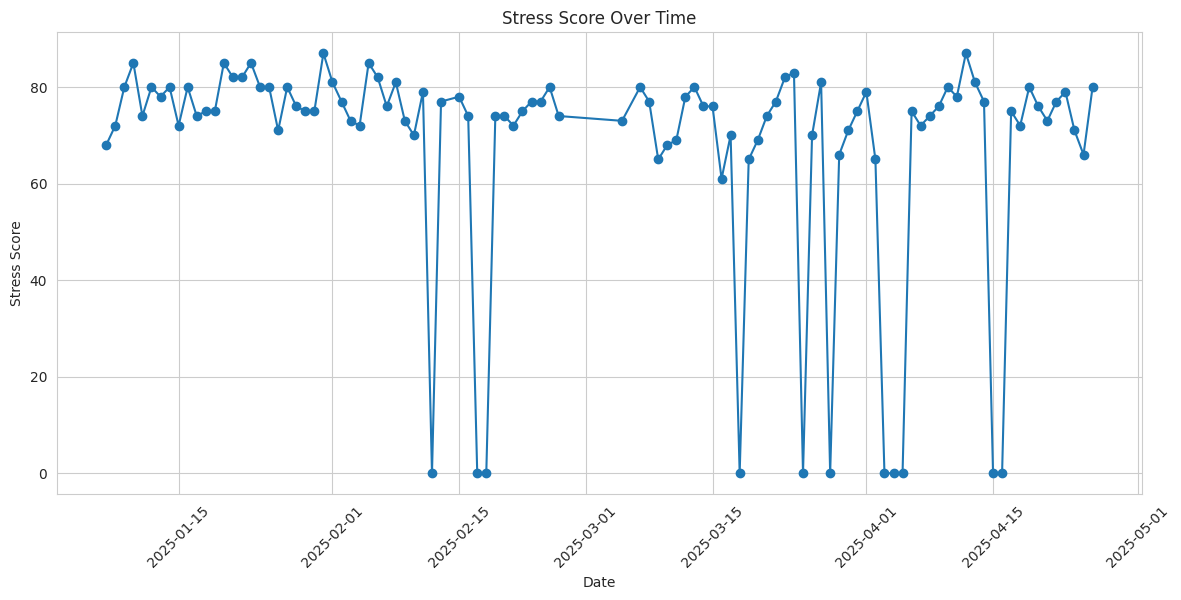

In [ ]:
import pandas as pd
stress_score = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/online behavior final/des data/Stress Score.csv')
stress_df = stress_score[['DATE', 'STRESS_SCORE']] # Select both 'DATE' and 'STRESS_SCORE'
stress_df['DATE'] = stress_df['DATE'].str.replace('T00:00:00', '') # Remove the time part
stress_df['Date'] = pd.to_datetime(stress_df['DATE']) # Convert the 'DATE' column to datetime
stress_df = stress_df.drop('DATE', axis=1) # Drop the original 'DATE' column
stress_df = stress_df.rename(columns={'STRESS_SCORE': 'Stress Score'}) # Rename the 'STRESS_SCORE' column to 'Stress Score'

stress_df = stress_df[['Date','Stress Score']]

stress_df = stress_df.loc[(stress_df['Date'] >= start_date) & (stress_df['Date'] <= end_date)] # Now you can filter
#stress_df.head()

mean_stress = stress_df['Stress Score'].mean()
print('Mean Stress Score:', mean_stress)

stress_df['Stress Spike'] = (stress_df['Stress Score'] > mean_stress).astype(int)
stres_df['Stress Dip'] = (stress_df['Stress Score'] < mean_stress).astype(int)

# plt.figure(figsize=(14, 6))
# plt.plot(stress_df['Date'], stress_df['Stress Score'], marker='o')
# plt.title('Stress Score Over Time')
# plt.xlabel('Date')
# plt.ylabel('Stress Score')
# plt.grid(True)
# plt.xticks(rotation=45)

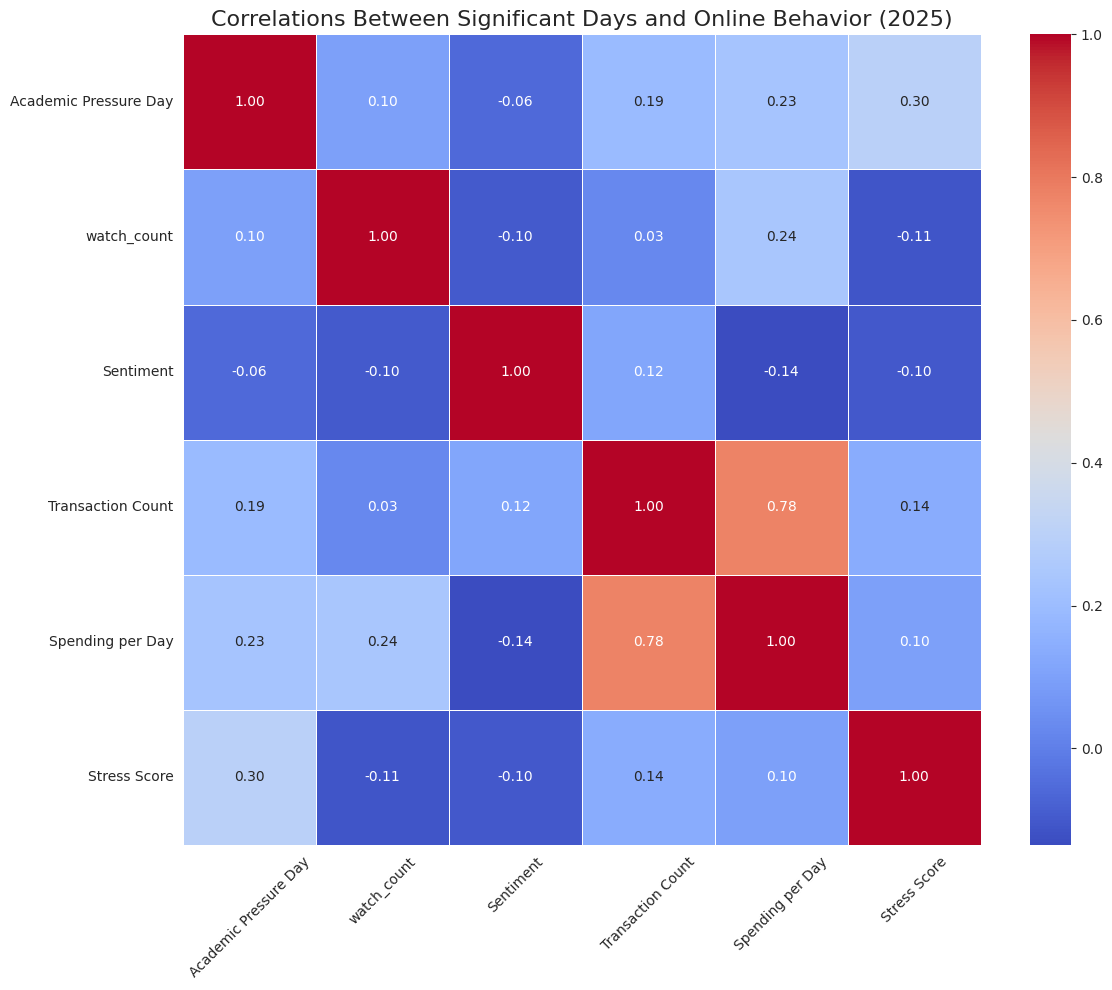

                       Academic Pressure Day  watch_count  Sentiment  \
Academic Pressure Day               1.000000     0.095542  -0.055967   
watch_count                         0.095542     1.000000  -0.097320   
Sentiment                          -0.055967    -0.097320   1.000000   
Transaction Count                   0.192669     0.025456   0.116685   
Spending per Day                    0.228633     0.238345  -0.135140   
Stress Score                        0.298709    -0.112180  -0.101112   

                       Transaction Count  Spending per Day  Stress Score  
Academic Pressure Day           0.192669          0.228633      0.298709  
watch_count                     0.025456          0.238345     -0.112180  
Sentiment                       0.116685         -0.135140     -0.101112  
Transaction Count               1.000000          0.778236      0.136963  
Spending per Day                0.778236          1.000000      0.095626  
Stress Score                    0.136963     

In [ ]:
final_merged = pd.merge(combined, youtube_daily_df , on='Date')
final_merged = pd.merge(final_merged, daily_food, on='Date')
final_merged = pd.merge(final_merged, binary_series, on='Date')
final_merged = pd.merge(final_merged, stress_df, on='Date')
final_merged['Sentiment'] = final_merged['Sentiment'].fillna(0)


# 1. Select only the columns you want to correlate
online_behavior_cols = [
    'Academic Pressure Day',
    'watch_count',
    'Sentiment',
    'Transaction Count',
    'Spending per Day',
    'Stress Score'
]

# 2. Compute the correlation matrix
correlations = final_merged[online_behavior_cols].corr()

# 3. Display nicely
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlations Between Significant Days and Online Behavior (2025)', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Optional: Also print numeric table
print(correlations)

In [ ]:
import pandas as pd
from scipy.stats import pearsonr


significant_series = final_merged['Academic Pressure Day']

# --- 3. Threshold online behavior into spikes/drops ---
threshold_multiplier = 1.0

columns_to_threshold = [
    'watch_count',
    'Sentiment',
    'Transaction Count',
    'Spending per Day',
    'Stress Score'
]
binary_behavior = pd.DataFrame(index=final_merged.index)

for col in columns_to_threshold:
    mean_val = final_merged[col].mean()
    std_val = final_merged[col].std()

    binary_behavior[col + '_positive_spike'] = (final_merged[col] > mean_val + threshold_multiplier * std_val).astype(int)
    binary_behavior[col + '_negative_drop'] = (final_merged[col] < mean_val - threshold_multiplier * std_val).astype(int)

# --- 4. Compute Pearson correlations ---
all_results = {}
significant_results = []

for col in binary_behavior.columns:
    corr, pval = pearsonr(significant_series, binary_behavior[col])
    all_results[col] = (corr, pval)

    if abs(corr) > 0.2 and pval < 0.05:
        significant_results.append((col, corr, pval))

# --- 5. Display all correlations ---
print("\n=== All Correlation Results with Significant Academic Day ===\n")
for col, (corr, pval) in all_results.items():
    print(f"{col}: correlation = {corr:.3f}, p-value = {pval:.4f}")

# --- 6. Display only significant ones ---
print("\n=== Statistically Significant and Strong Correlations (|corr| > 0.2, p < 0.05) ===\n")
if significant_results:
    significant_results.sort(key=lambda x: abs(x[1]), reverse=True)

    for col, corr, pval in significant_results:
        print(f"{col}: correlation = {corr:.3f}, p-value = {pval:.4f}")
else:
    print("No strong and statistically significant correlations found.")



=== All Correlation Results with Significant Academic Day ===

watch_count_positive_spike: correlation = 0.204, p-value = 0.2011
watch_count_negative_drop: correlation = nan, p-value = nan
Sentiment_positive_spike: correlation = -0.068, p-value = 0.6719
Sentiment_negative_drop: correlation = -0.005, p-value = 0.9773
Transaction Count_positive_spike: correlation = 0.204, p-value = 0.2011
Transaction Count_negative_drop: correlation = nan, p-value = nan
Spending per Day_positive_spike: correlation = 0.162, p-value = 0.3119
Spending per Day_negative_drop: correlation = 0.078, p-value = 0.6285
Stress Score_positive_spike: correlation = nan, p-value = nan
Stress Score_negative_drop: correlation = -0.319, p-value = 0.0424

=== Statistically Significant and Strong Correlations (|corr| > 0.2, p < 0.05) ===

Stress Score_negative_drop: correlation = -0.319, p-value = 0.0424


<ipython-input-56-b5d3bb1641fd>:31: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = pearsonr(significant_series, binary_behavior[col])


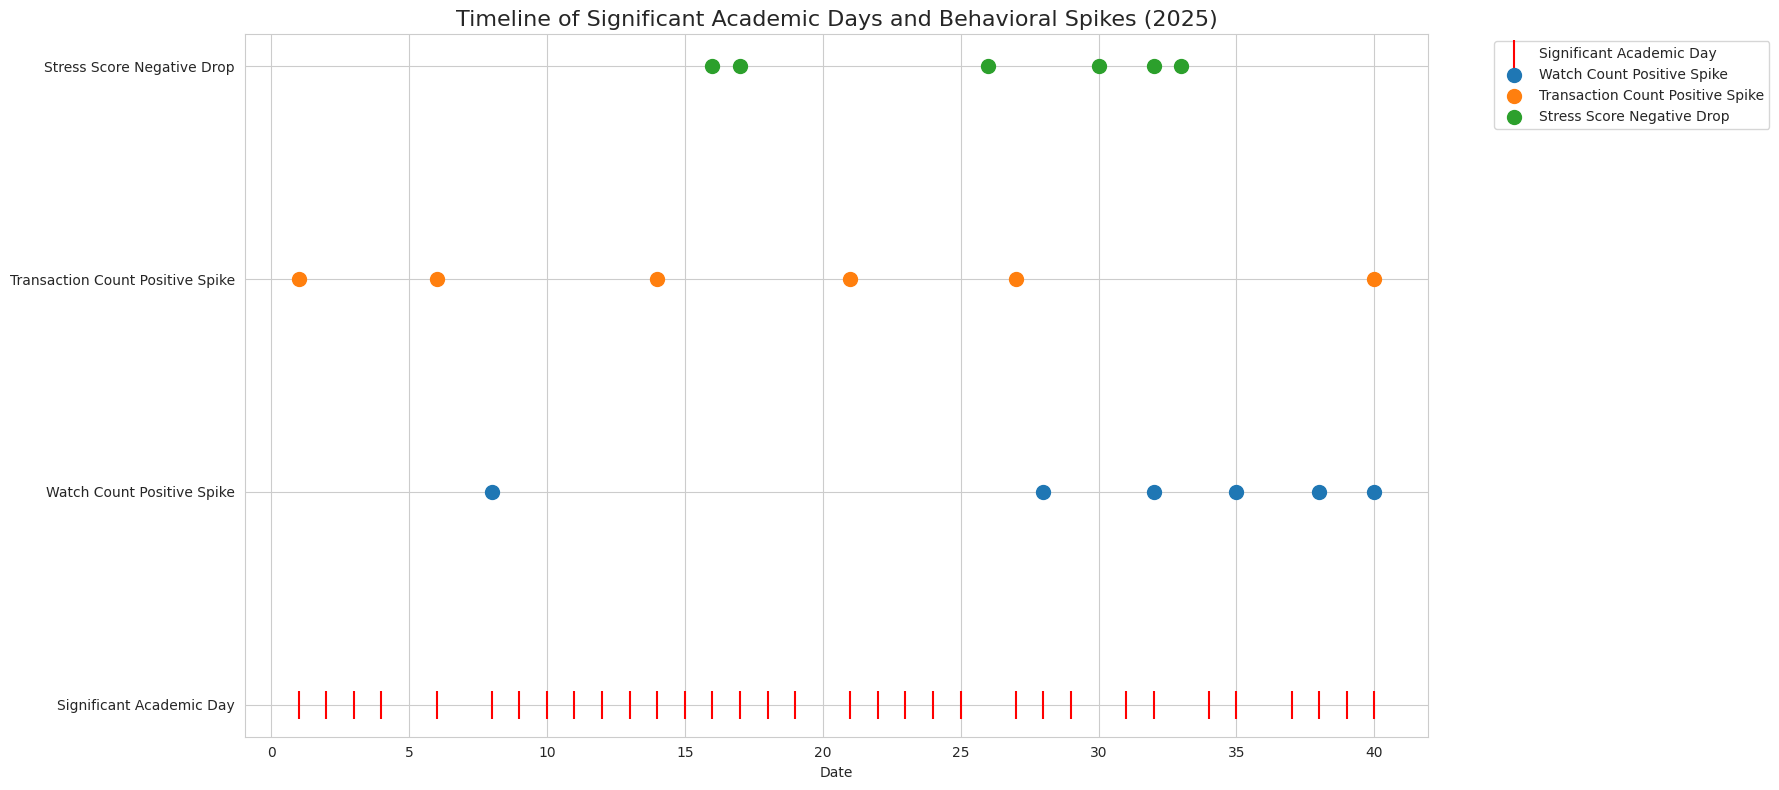

In [ ]:
import matplotlib.pyplot as plt

# -------------------------
# 1. Pick a few interesting behaviors to visualize
# -------------------------
# You can change which behaviors you want to plot!
behaviors_to_plot = [
    'watch_count_positive_spike',
    'Transaction Count_positive_spike',
    'Stress Score_negative_drop'
]

# -------------------------
# 2. Prepare the figure
# -------------------------
plt.figure(figsize=(18, 8))

# Vertical offset for stacking each behavior
offset = 0

# -------------------------
# 3. Plot Significant Academic Days
# -------------------------
plt.scatter(
    final_merged.index[final_merged['Academic Pressure Day'] == 1],
    [offset] * sum(final_merged['Academic Pressure Day']),
    color='red',
    marker='|',
    s=400,
    label='Significant Academic Day'
)

offset += 1  # Move up

# -------------------------
# 4. Plot each behavior's spikes
# -------------------------
for behavior in behaviors_to_plot:
    if behavior in binary_behavior.columns:
        spike_dates = binary_behavior.index[binary_behavior[behavior] == 1]
        plt.scatter(
            spike_dates,
            [offset] * len(spike_dates),
            label=behavior.replace('_', ' ').title(),
            s=100
        )
        offset += 1  # Move up for next behavior

# -------------------------
# 5. Finishing touches
# -------------------------
plt.title('Timeline of Significant Academic Days and Behavioral Spikes (2025)', fontsize=16)
plt.yticks(
    range(len(behaviors_to_plot) + 1),
    ['Significant Academic Day'] + [b.replace('_', ' ').title() for b in behaviors_to_plot]
)
plt.xlabel('Date')
plt.grid(True, axis='x')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
